# Prostate Cancer - Exploratory Data Analysis

## 1. Import Libraries

In [147]:
import os
import openslide
import skimage.io
import random
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import PIL
from IPython.display import Image, display
import plotly.graph_objs as go

## 2. Set Path Variables

In [148]:
BASE_PATH = '../input/prostate-cancer-grade-assessment'

# image and mask directories
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'


# Location of training labels
train = pd.read_csv(f'{BASE_PATH}/train.csv')#.set_index('image_id')
test = pd.read_csv(f'{BASE_PATH}/test.csv')
#submission = pd.read_csv(f'{BASE_PATH}/sample_submission.csv')

## 3. Statistics for Train Dataset 

In [149]:
print("Training data Shape :", train.shape)

print("\nSample Training Records")
display(train.head())


print("# of Samples by each Data Provider")
display(train[["data_provider","isup_grade"]].groupby('data_provider').count())

print("Gleason Score Unique Values:", len(train.gleason_score.unique()))
print("ISUP Grade Unique Values:", len(train.isup_grade.unique()))

Training data Shape : (10616, 4)

Sample Training Records


,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


# of Samples by each Data Provider


,isup_grade
data_provider,
karolinska,5456
radboud,5160


Gleason Score Unique Values: 11
ISUP Grade Unique Values: 6


In [150]:
print("Image Count by Gleason Score")
train['gleason_score'] = train['gleason_score'].apply(lambda x: "0+0" if x=="negative" else x)
temp = train.groupby('gleason_score').count()['image_id'].reset_index().sort_values(by='gleason_score',ascending=True)
temp.style.background_gradient(cmap='Oranges')

Image Count by Gleason Score


,gleason_score,image_id
0,0+0,2892
1,3+3,2666
2,3+4,1342
3,3+5,80
4,4+3,1243
5,4+4,1126
6,4+5,849
7,5+3,43
8,5+4,248
9,5+5,127


In [151]:
print("Image Count by ISUP Grade")
temp = train.copy()
temp['isup_grade'] = temp['isup_grade'].astype('str', copy=False)
temp = temp.groupby('isup_grade').count()['image_id'].reset_index().sort_values(by='image_id',ascending=False)
temp.style.background_gradient(cmap='Oranges')

Image Count by ISUP Grade


,isup_grade,image_id
0,0,2892
1,1,2666
2,2,1343
4,4,1249
3,3,1242
5,5,1224


## 4. Explore Samples Distribution

In [152]:
def plot_count(df, feature, title='', size=2):
    f, ax = plt.subplots(1,1, figsize=(6*size,3*size))
    total = float(len(df))
    sns.countplot(df[feature],order = df[feature].value_counts().index, palette='Set3')
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()
    

ISUP Grades Distribution for given Samples


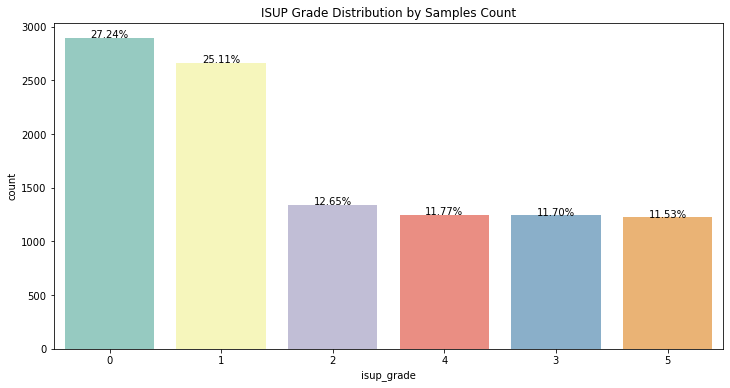

In [153]:
print("ISUP Grades Distribution for given Samples")
plot_count(df=train, feature='isup_grade', title = 'ISUP Grade Distribution by Samples Count')

In [154]:
def plot_relative_distribution(df, feature, hue, title='', size=2):
    print( np.sort(df[feature].unique()))
    f, ax = plt.subplots(1,1, figsize=(6*size,3*size))
    total = float(len(df))
    sns.countplot(x=feature, hue=hue, data=df, palette='Set1',order = np.sort(df[feature].unique()))
    plt.title(title)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center") 
    plt.show()

ISUP Grades Distribution by Data Providers
[0 1 2 3 4 5]


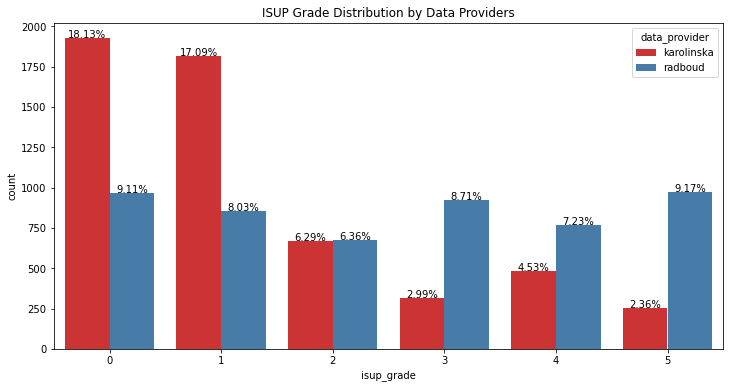

In [155]:
print("ISUP Grades Distribution by Data Providers")
plot_relative_distribution(df=train, feature='isup_grade', hue='data_provider',
                           title = 'ISUP Grade Distribution by Data Providers', size=2)

Gleason Scores Distribution by Data Providers
['0+0' '3+3' '3+4' '3+5' '4+3' '4+4' '4+5' '5+3' '5+4' '5+5']


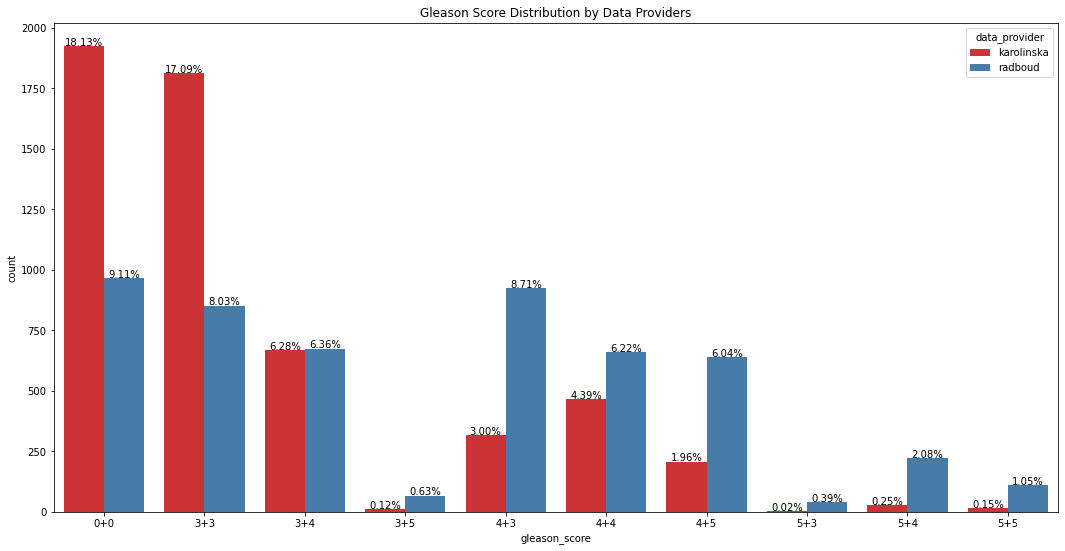

In [156]:
print("Gleason Scores Distribution by Data Providers")
plot_relative_distribution(df=train, feature='gleason_score', hue='data_provider', 
                           title = 'Gleason Score Distribution by Data Providers',size=3)

## 5. View Images Samples

In [157]:

def display_images(slides): 
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        image = openslide.OpenSlide(os.path.join(data_dir, f'{slide}.tiff'))
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region((1780,1950), 0, (256, 256))
        ax[i//3, i%3].imshow(patch) 
        image.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[i, 'data_provider']
        isup_grade = train.loc[i, 'isup_grade']
        gleason_score = train.loc[i, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

    plt.show()

Sample Images


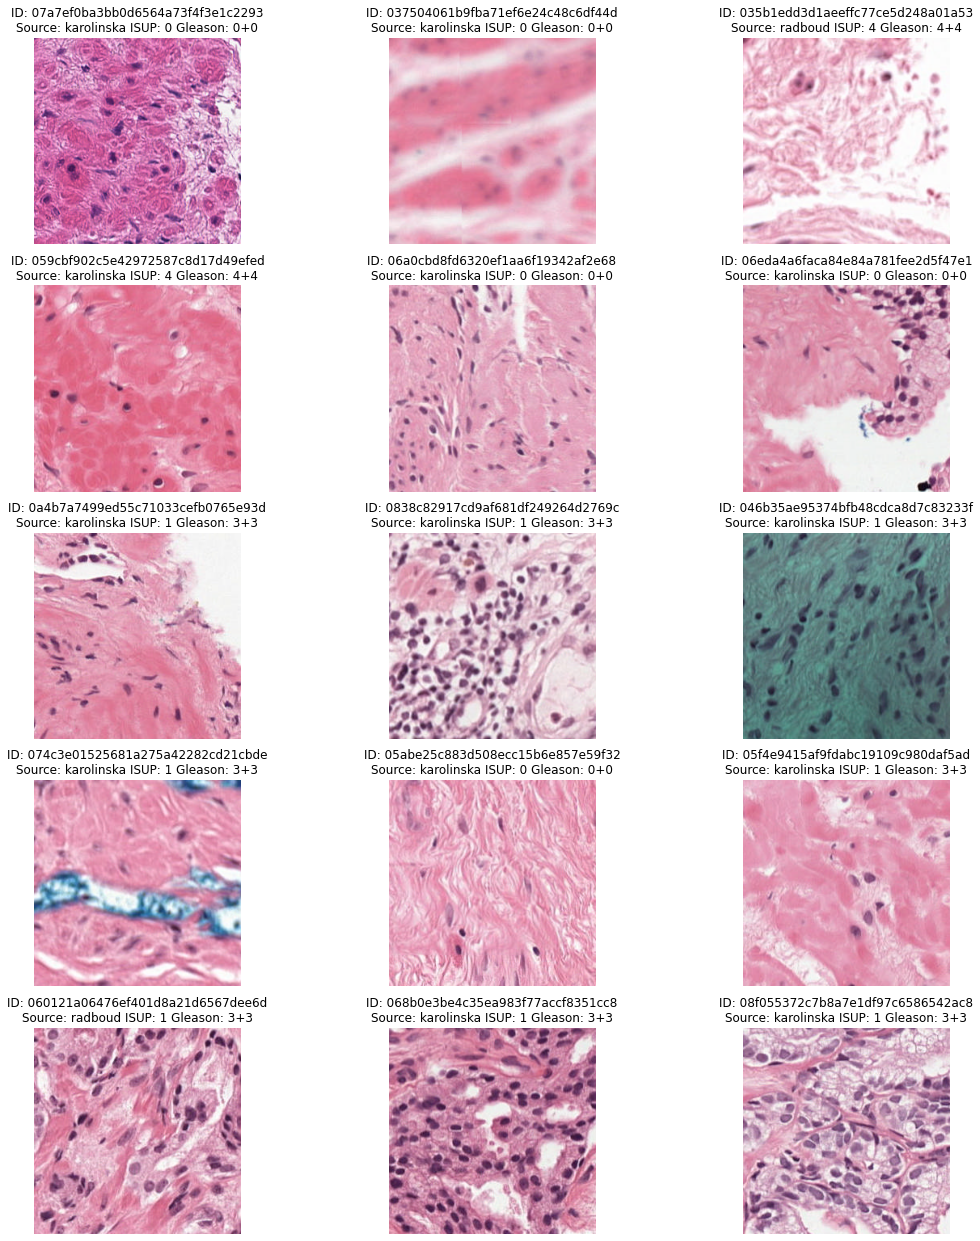

In [158]:
print("Sample Images")
images = [
'07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f',
    '074c3e01525681a275a42282cd21cbde',
    '05abe25c883d508ecc15b6e857e59f32',
    '05f4e9415af9fdabc19109c980daf5ad',
    '060121a06476ef401d8a21d6567dee6d',
    '068b0e3be4c35ea983f77accf8351cc8',
    '08f055372c7b8a7e1df97c6586542ac8'
]
display_images(images)

In [159]:
def display_masks(slides): 
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        
        mask = openslide.OpenSlide(os.path.join(mask_dir, f'{slide}_mask.tiff'))
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        uniqu

        ax[i//3, i%3].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = train.loc[i, 'data_provider']
        isup_grade = train.loc[i, 'isup_grade']
        gleason_score = train.loc[i, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")
        f.tight_layout()
        
    plt.show()

Sample Annotated Masks


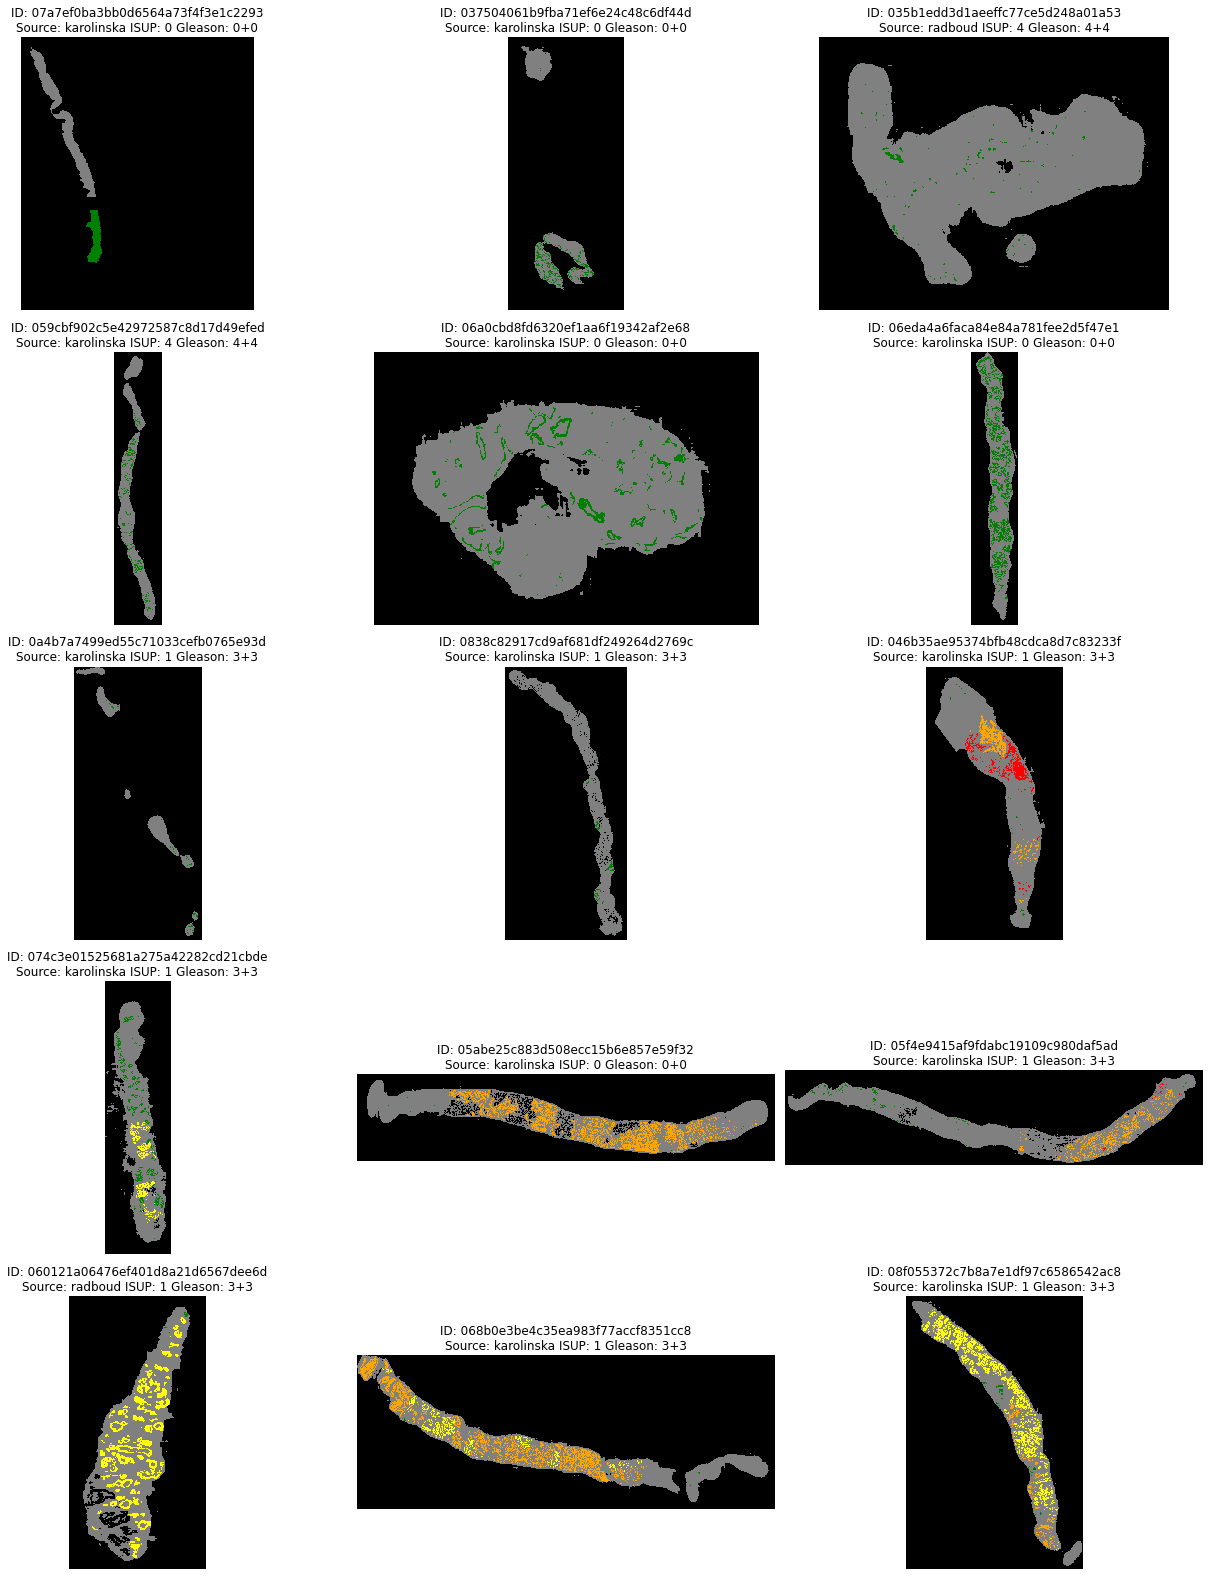

In [160]:
print("Sample Annotated Masks")
display_masks(images)

In [161]:
def mask_img(image,max_size=(600,400)):
    
    slide = openslide.OpenSlide(os.path.join(data_dir, f'{image}.tiff'))
    mask =  openslide.OpenSlide(os.path.join(mask_dir, f'{image}_mask.tiff'))
    # Here we compute the "pixel spacing": the physical size of a pixel in the image.
    # OpenSlide gives the resolution in centimeters so we convert this to microns.
    f,ax =  plt.subplots(1,2 ,figsize=(18,22))
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    img = slide.get_thumbnail(size=(600,400)) #IMAGE 
    
    mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
    cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])
    
    ax[0].imshow(img) 
    #ax[0].set_title('Image')
    
    
    ax[1].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) #IMAGE MASKS
    #ax[1].set_title('Image_MASK')
    
    
    image_id = image
    #data_provider = train.loc[image, 'data_provider']
    #isup_grade = train.loc[image, 'isup_grade']
    #gleason_score = train.loc[image, 'gleason_score']
    #ax[0].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE")
    #ax[1].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score} IMAGE_MASK")

Sample Images and Annotated Masks


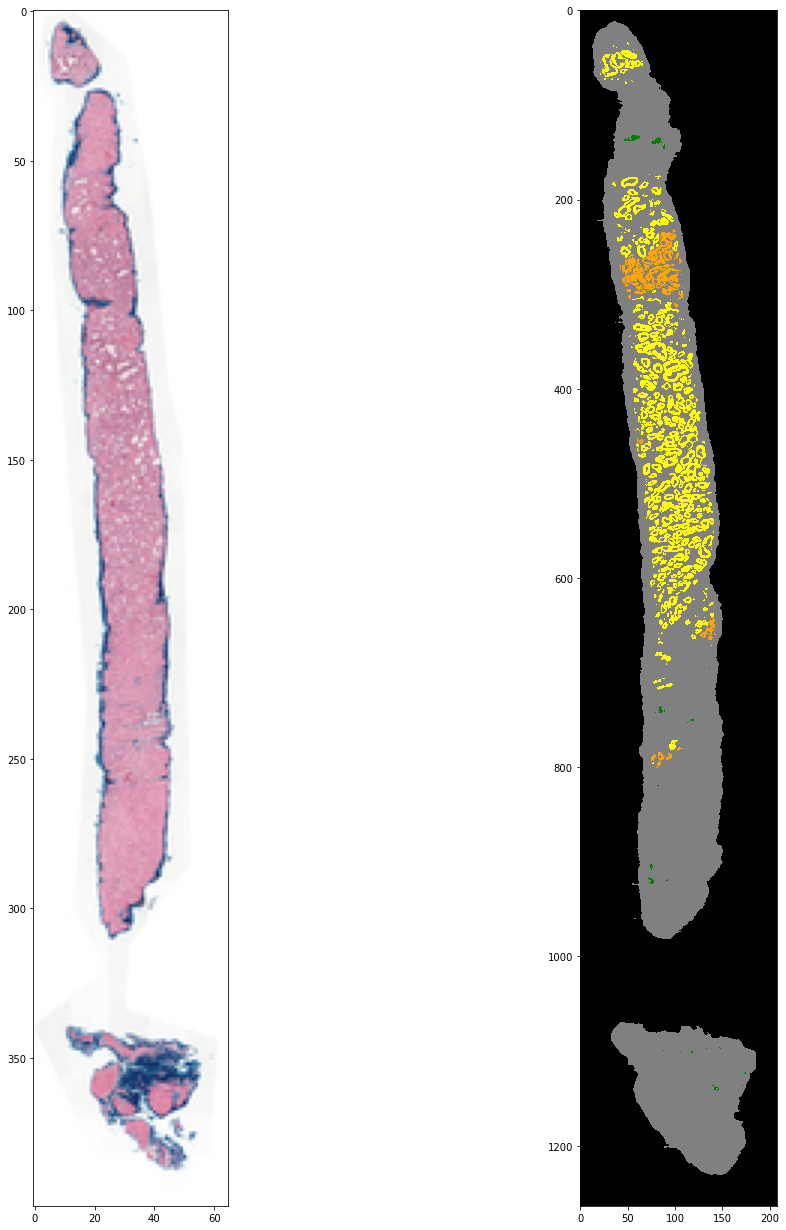

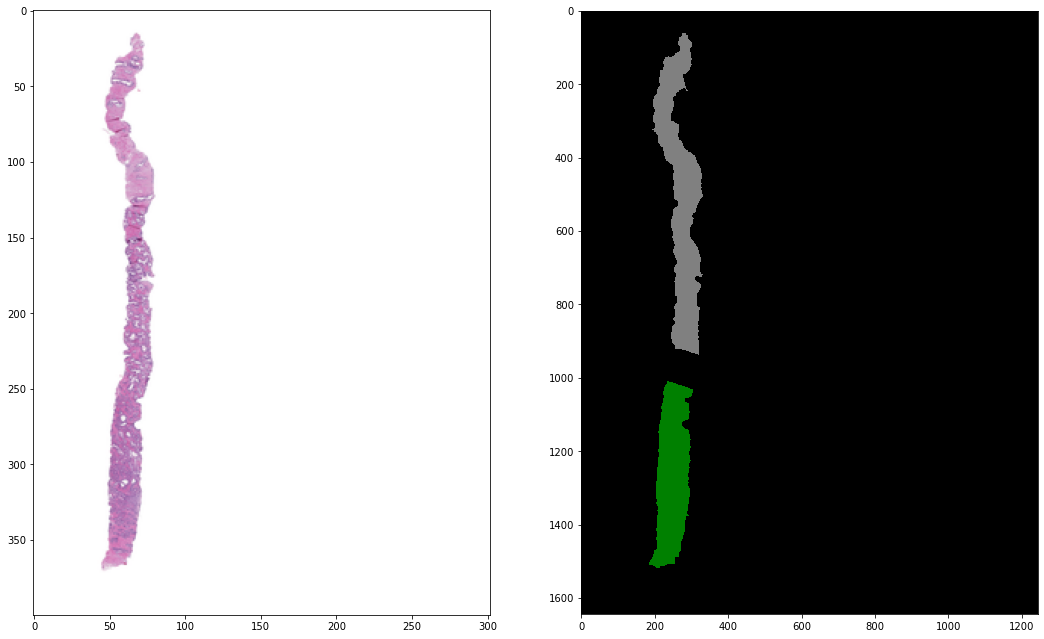

In [162]:
print("Sample Images and Annotated Masks")

images1= [
    '08ab45297bfe652cc0397f4b37719ba1',
    '090a77c517a7a2caa23e443a77a78bc7'
]

for image in images1:
    mask_img(image)

In [163]:
def overlay_mask_on_slide(images, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""
    f, ax = plt.subplots(2,3, figsize=(18,22))
    
    
    for i, image_id in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(data_dir, f'{image_id}.tiff'))
        mask = openslide.OpenSlide(os.path.join(mask_dir, f'{image_id}_mask.tiff'))
        slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        mask_data = mask_data.split()[0]
        
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)

        
        ax[i//3, i%3].imshow(overlayed_image) 
        slide.close()
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        data_provider = train.loc[i, 'data_provider']
        isup_grade = train.loc[i, 'isup_grade']
        gleason_score = train.loc[i, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

Samples Images with Overlayed Masks


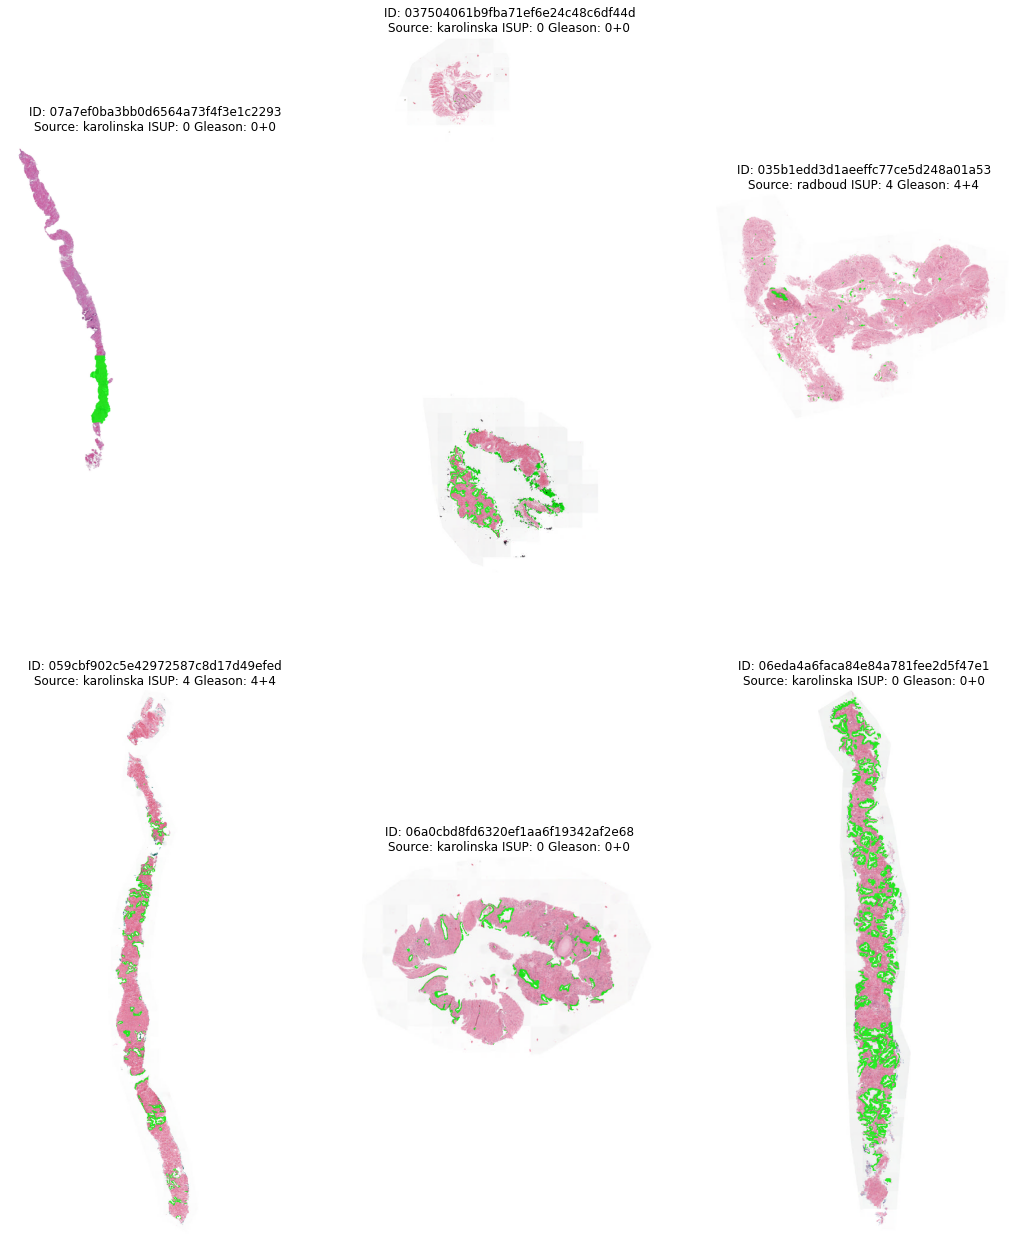

In [164]:
print("Samples Images with Overlayed Masks")
overlay_mask_on_slide(images[:6])

In [165]:
def overlay_mask_on_slide(images, center='radboud', alpha=0.8, max_size=(800, 800)):
    """Show a mask overlayed on a slide."""
    f, ax = plt.subplots(5,3, figsize=(18,22))
    
    
    for i, image_id in enumerate(images):
        slide = openslide.OpenSlide(os.path.join(data_dir, f'{image_id}.tiff'))
        mask = openslide.OpenSlide(os.path.join(mask_dir, f'{image_id}_mask.tiff'))
        slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        mask_data = mask_data.split()[0]
        
        
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)

        
        ax[i//3, i%3].imshow(overlayed_image) 
        slide.close()
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        data_provider = train.loc[i, 'data_provider']
        isup_grade = train.loc[i, 'isup_grade']
        gleason_score = train.loc[i, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

Sample Images with Marker highlights


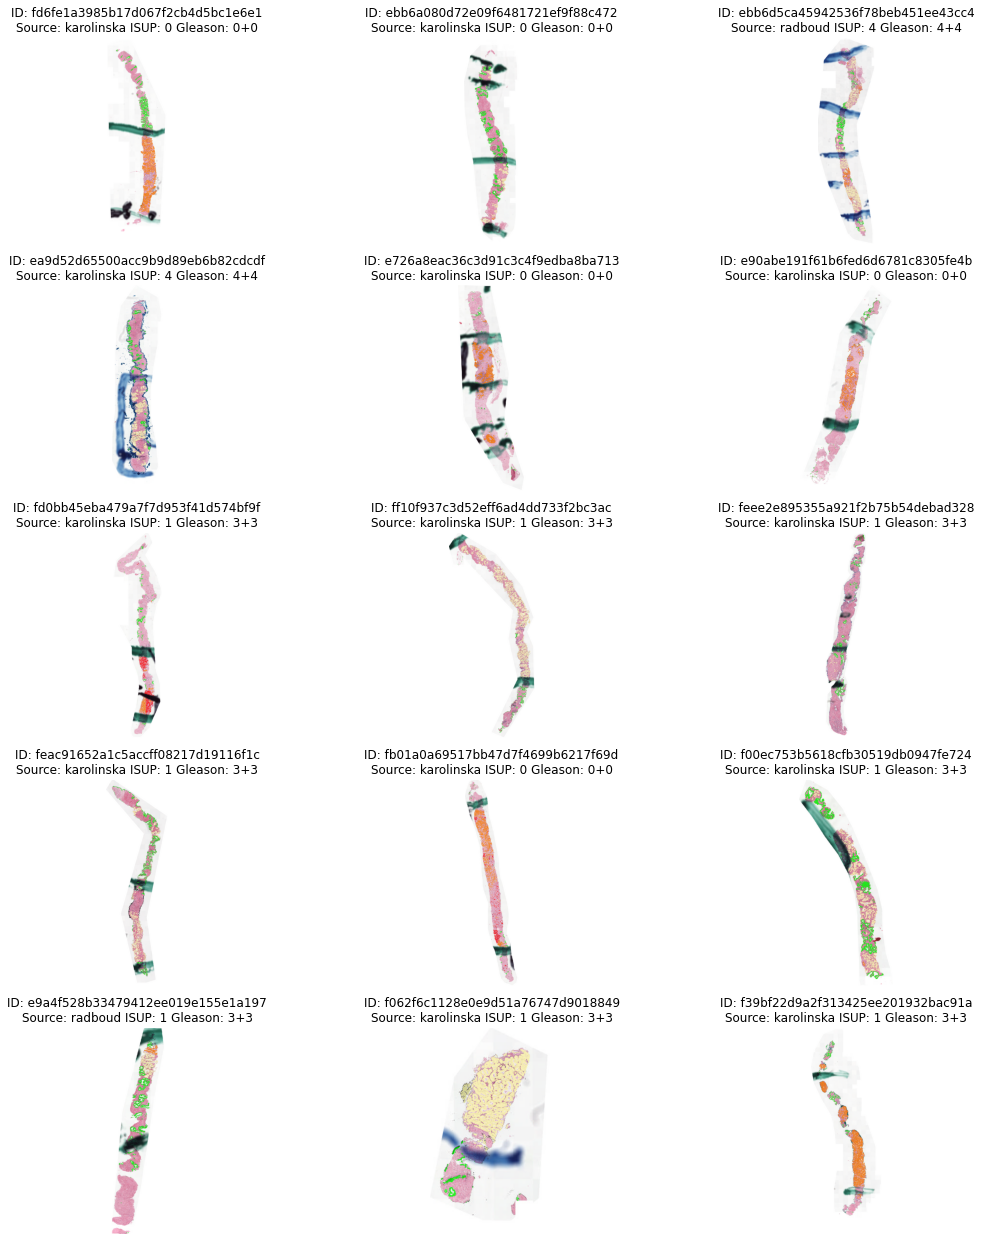

In [166]:
pen_marked_images = [
    'fd6fe1a3985b17d067f2cb4d5bc1e6e1',
    'ebb6a080d72e09f6481721ef9f88c472',
    'ebb6d5ca45942536f78beb451ee43cc4',
    'ea9d52d65500acc9b9d89eb6b82cdcdf',
    'e726a8eac36c3d91c3c4f9edba8ba713',
    'e90abe191f61b6fed6d6781c8305fe4b',
    'fd0bb45eba479a7f7d953f41d574bf9f',
    'ff10f937c3d52eff6ad4dd733f2bc3ac',
    'feee2e895355a921f2b75b54debad328',
    'feac91652a1c5accff08217d19116f1c',
    'fb01a0a69517bb47d7f4699b6217f69d',
    'f00ec753b5618cfb30519db0947fe724',
    'e9a4f528b33479412ee019e155e1a197',
    'f062f6c1128e0e9d51a76747d9018849',
    'f39bf22d9a2f313425ee201932bac91a',
]

print("Sample Images with Marker highlights")
overlay_mask_on_slide(pen_marked_images)